In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

In [3]:
# Kích thước bàn cờ (số góc bên trong)
# Ví dụ: bàn cờ 9x6 có 8x5 góc bên trong
CHECKERBOARD = (8, 5)  # Điều chỉnh số này theo bàn cờ của bạn

# Mảng lưu điểm 3D thực tế và điểm 2D trong ảnh
objpoints = []  # 3D points
imgpoints = []  # 2D points

# Tạo điểm 3D thực tế (0,0,0), (1,0,0), (2,0,0) ...
objp = np.zeros((CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)

# Đọc tất cả ảnh từ thư mục
images = glob.glob('Image/*.jpg')  # Điều chỉnh đường dẫn

# Biến lưu kích thước ảnh
img_size = None

print(f"Tìm thấy {len(images)} ảnh để hiệu chuẩn")

Tìm thấy 11 ảnh để hiệu chuẩn


Ảnh 1: Tìm thấy 40 góc


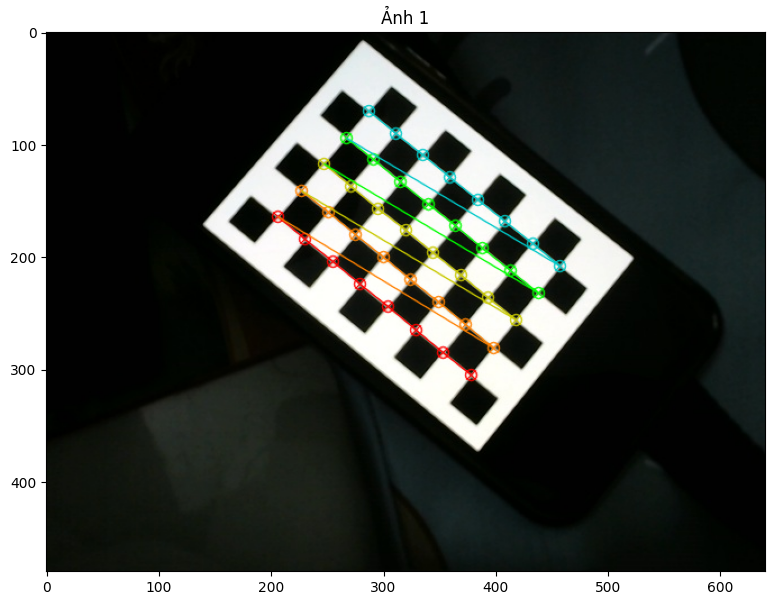

Ảnh 2: Tìm thấy 40 góc


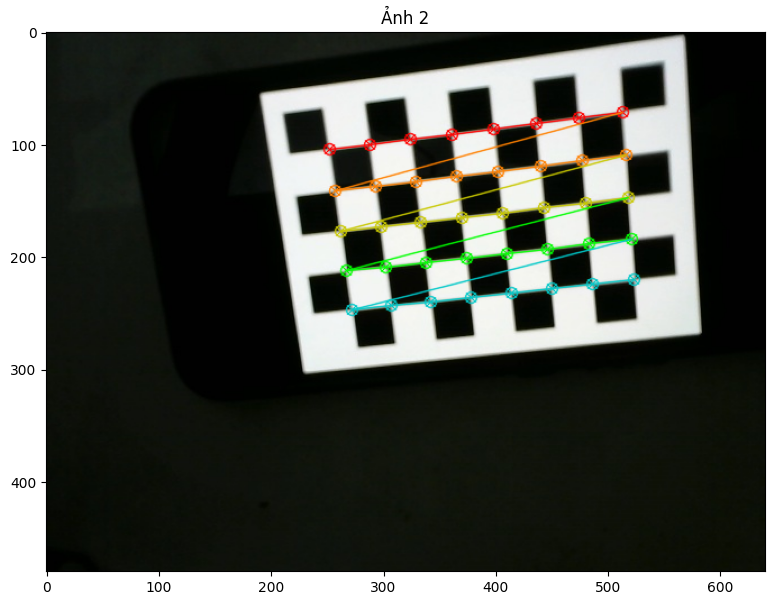

Ảnh 3: Tìm thấy 40 góc


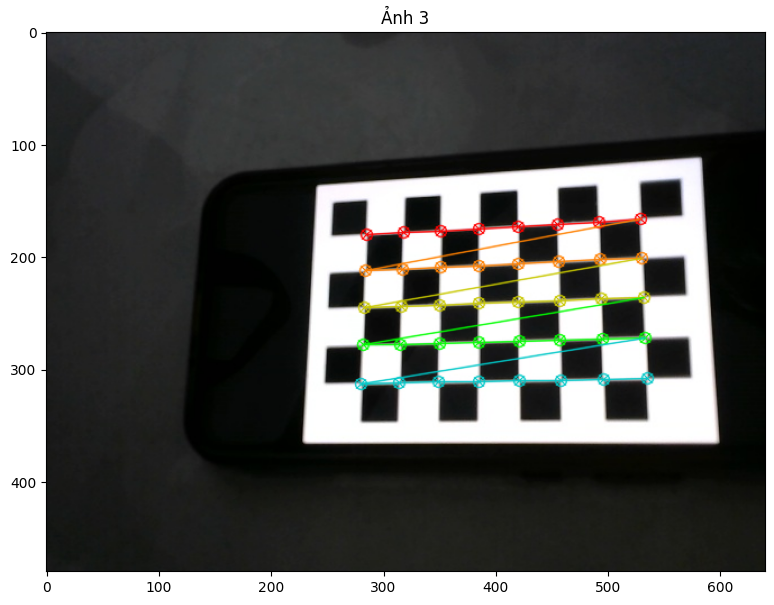

Ảnh 4: Tìm thấy 40 góc


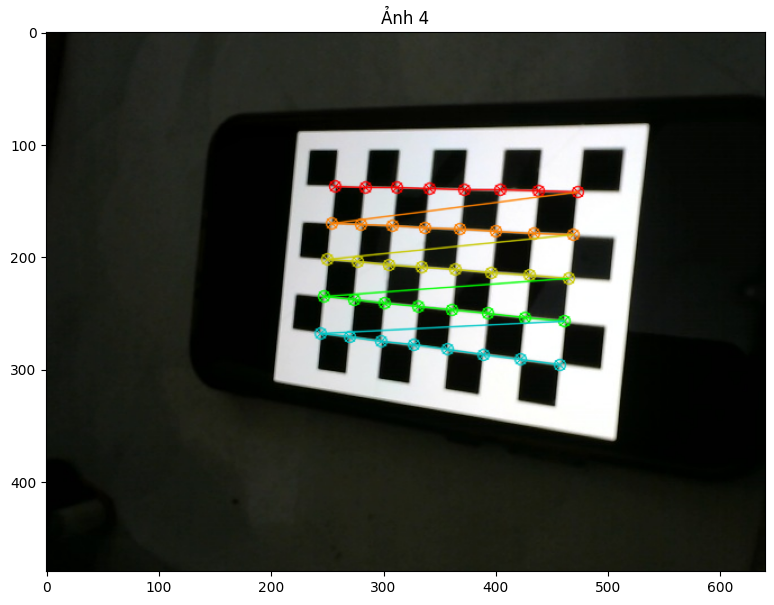

Ảnh 5: Tìm thấy 40 góc


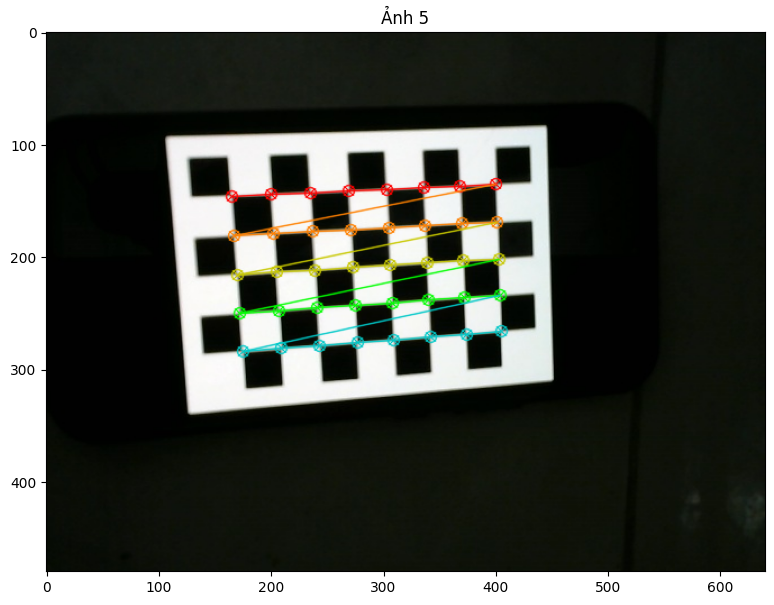

Ảnh 6: Tìm thấy 40 góc


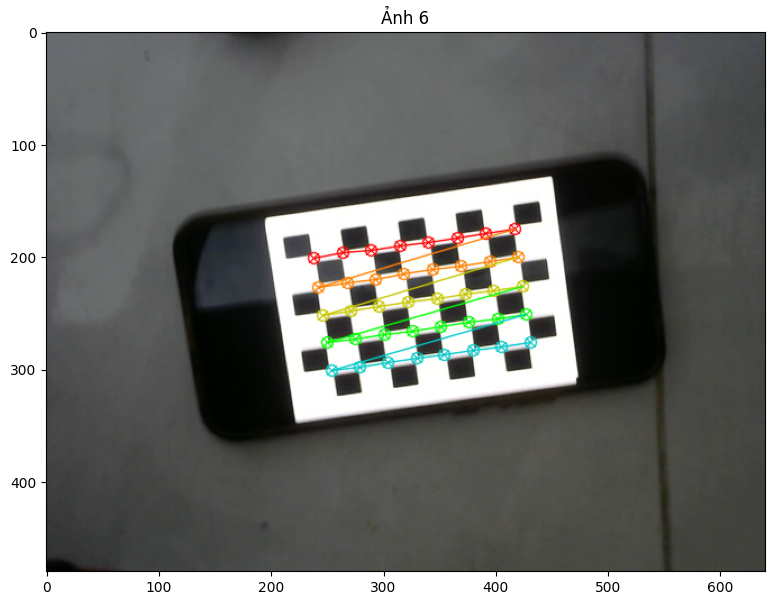

Ảnh 7: Tìm thấy 40 góc


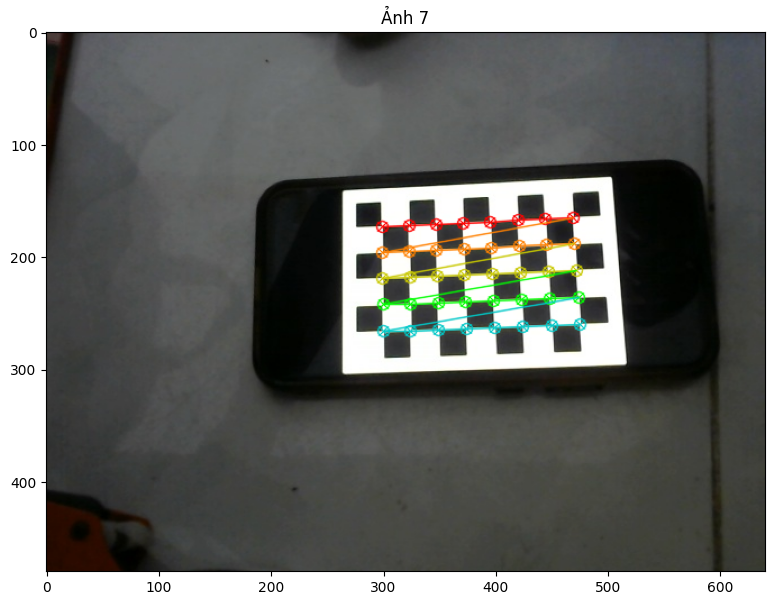

Ảnh 8: Tìm thấy 40 góc


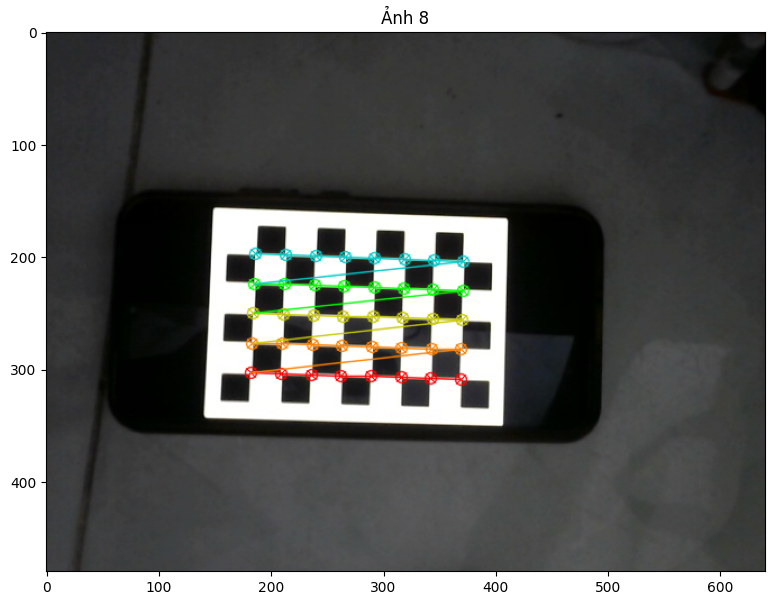

Ảnh 9: Tìm thấy 40 góc


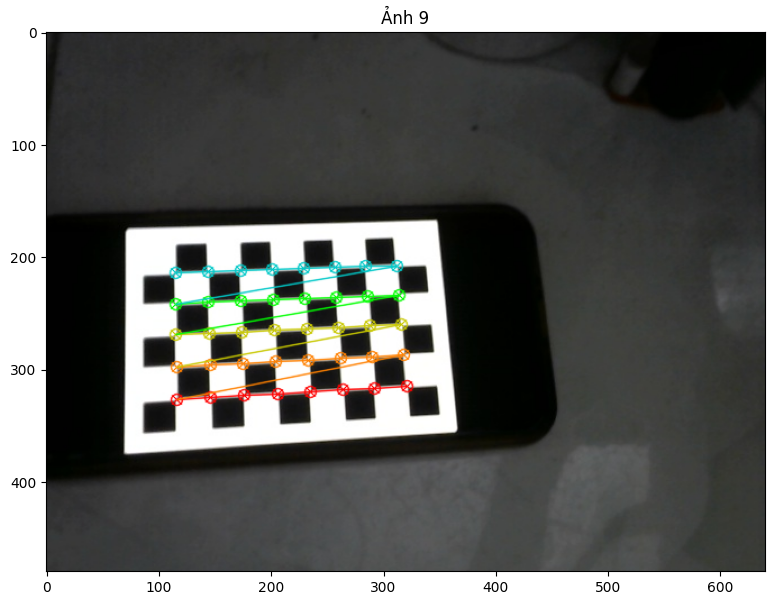

Ảnh 10: Tìm thấy 40 góc


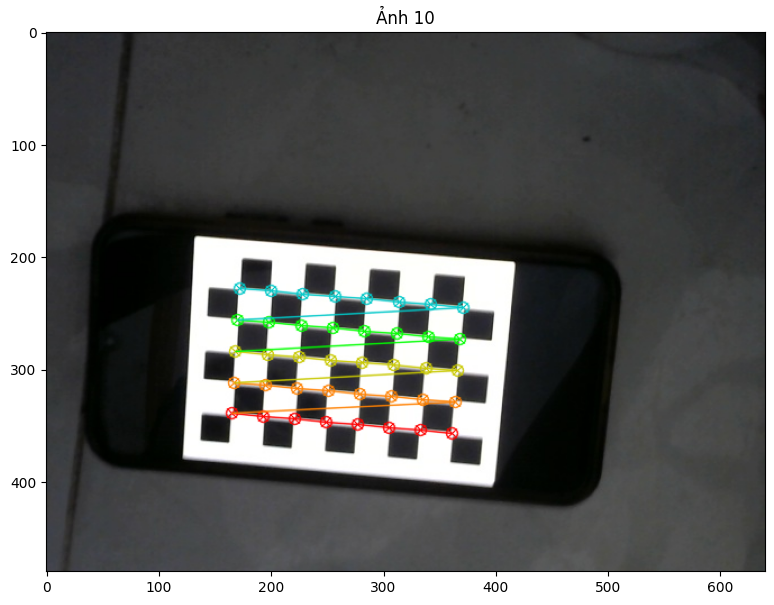

Ảnh 11: Tìm thấy 40 góc


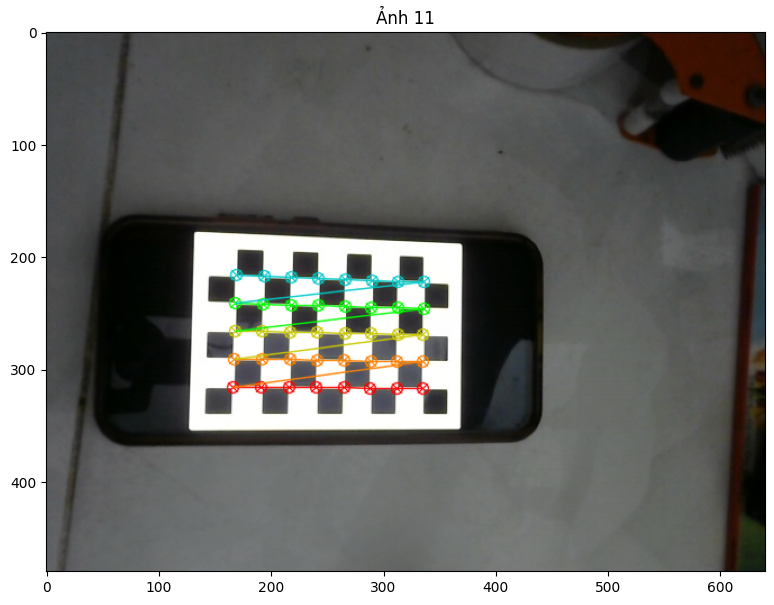

In [4]:
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    if img is None:
        print(f"Không thể đọc ảnh: {fname}")
        continue
        
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Lưu kích thước ảnh nếu chưa có
    if img_size is None:
        img_size = gray.shape[::-1]
    
    # Tìm các góc bàn cờ
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, 
                                             cv2.CALIB_CB_ADAPTIVE_THRESH + 
                                             cv2.CALIB_CB_FAST_CHECK + 
                                             cv2.CALIB_CB_NORMALIZE_IMAGE)
    
    if ret:
        print(f"Ảnh {i+1}: Tìm thấy {len(corners)} góc")
        # Tinh chỉnh vị trí góc
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        
        # Lưu điểm
        objpoints.append(objp)
        imgpoints.append(corners2)
        
        # Vẽ và hiển thị các góc đã tìm thấy (tùy chọn)
        img_corners = img.copy()
        cv2.drawChessboardCorners(img_corners, CHECKERBOARD, corners2, ret)
        
        # Hiển thị ảnh với các góc đã phát hiện (tùy chọn)
        plt.figure(figsize=(10, 7))
        plt.imshow(cv2.cvtColor(img_corners, cv2.COLOR_BGR2RGB))
        plt.title(f"Ảnh {i+1}")
        plt.show()
    else:
        print(f"Ảnh {i+1}: Không tìm thấy đủ góc bàn cờ")

In [5]:
# Hiệu chuẩn camera
if len(objpoints) > 0:
    print("\nĐang hiệu chuẩn camera...")
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
        objpoints, imgpoints, img_size, None, None)
    
    print("\nKết quả hiệu chuẩn:")
    print("Ma trận camera (camera matrix):")
    print(mtx)
    print("\nHệ số méo hình (distortion coefficients):")
    print(dist)
    
    # Tính lỗi tái chiếu
    mean_error = 0
    for i in range(len(objpoints)):
        imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
        error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
        mean_error += error
    
    print(f"\nLỗi tái chiếu trung bình: {mean_error/len(objpoints)}")
    
    # Lưu kết quả hiệu chuẩn
    # np.savez('camera_calibration.npz', mtx=mtx, dist=dist)
    # print("\nĐã lưu kết quả hiệu chuẩn vào camera_calibration.npz")


Đang hiệu chuẩn camera...

Kết quả hiệu chuẩn:
Ma trận camera (camera matrix):
[[809.83917054   0.         315.51253476]
 [  0.         809.00079983 253.72235228]
 [  0.           0.           1.        ]]

Hệ số méo hình (distortion coefficients):
[[-5.93491632e-03  9.70068626e-01  1.90843203e-03 -3.95096430e-03
  -2.85492041e+00]]

Lỗi tái chiếu trung bình: 0.018548762570339338


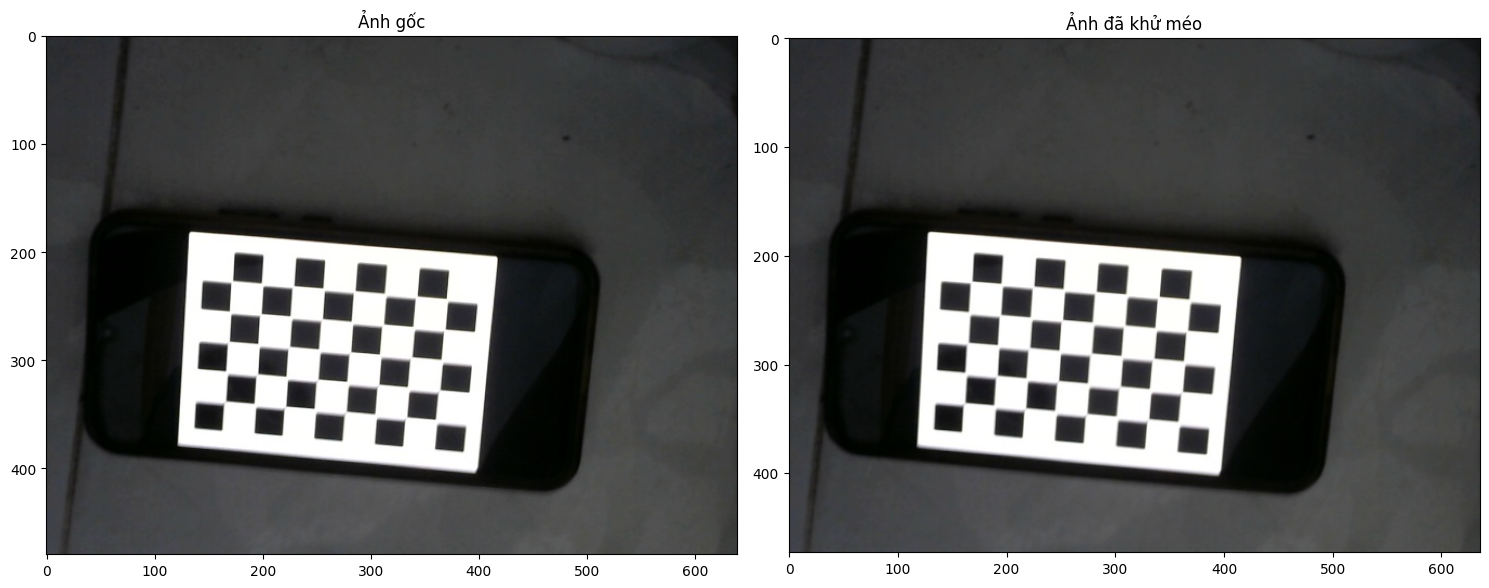

Đã lưu ảnh gốc và ảnh đã khử méo


In [35]:
if len(objpoints) > 0:
    # Hiển thị kết quả trên một ảnh mẫu
    if len(images) > 0:
        img = cv2.imread(images[9])
        h, w = img.shape[:2]

        # Lấy ma trận camera mới để tối ưu hóa kết quả
        newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
        
        # Khử méo hình
        dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
        
        # Cắt vùng quan tâm
        x, y, w, h = roi
        if all(v > 0 for v in [x, y, w, h]):
            dst = dst[y:y+h, x:x+w]
        
        # Hiển thị kết quả
        plt.figure(figsize=(15, 7))
        plt.subplot(121)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Ảnh gốc')
        plt.subplot(122)
        plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
        plt.title('Ảnh đã khử méo')
        plt.tight_layout()
        plt.show()
        
        # Lưu ảnh kết quả
        cv2.imwrite('original.jpg', img)
        cv2.imwrite('undistorted.jpg', dst)
        print("Đã lưu ảnh gốc và ảnh đã khử méo")
else:
    print("Không tìm thấy đủ ảnh có góc bàn cờ để hiệu chuẩn")

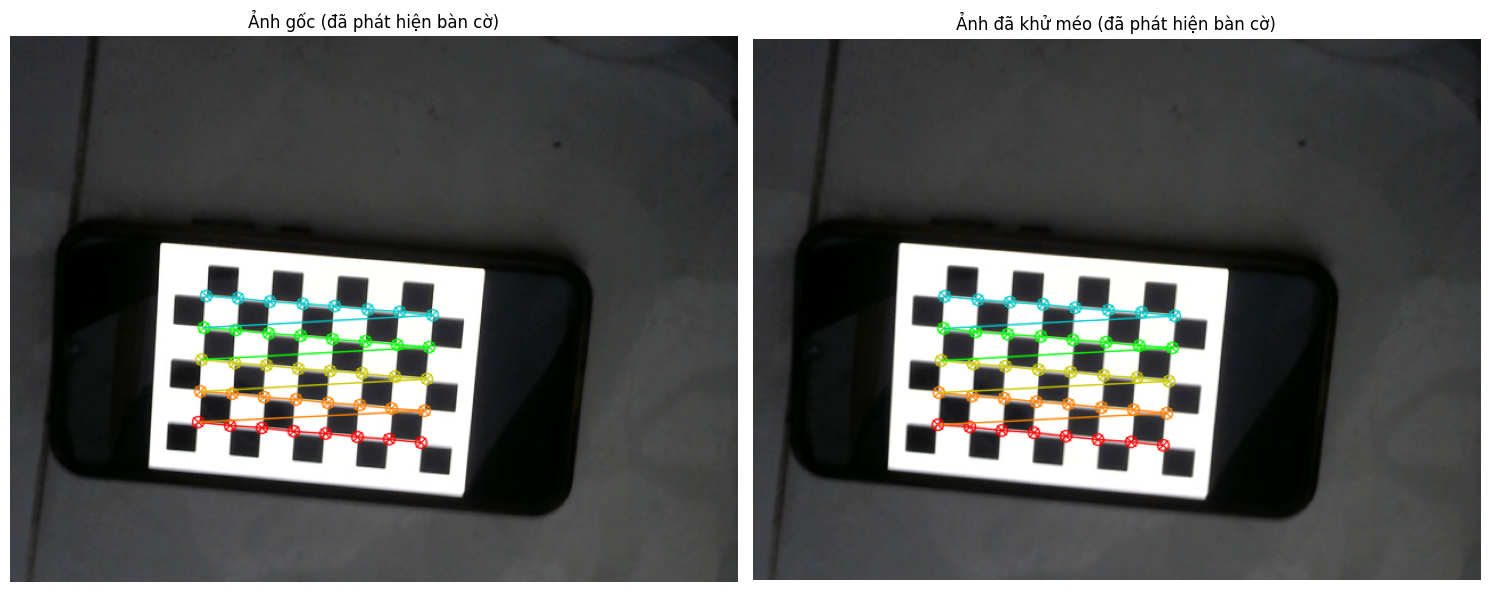

In [36]:
pattern_size = (8, 5)  # tức bàn cờ 8x7 ô → 7x6 góc

# Hàm phát hiện và vẽ bàn cờ
def detect_and_draw_corners(image, pattern_size):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    found, corners = cv2.findChessboardCorners(gray, pattern_size, None)

    image_drawn = image.copy()
    if found:
        # Tăng độ chính xác vị trí điểm góc
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        corners_subpix = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)

        # Vẽ các điểm góc
        cv2.drawChessboardCorners(image_drawn, pattern_size, corners_subpix, found)

    return image_drawn, found

# Áp dụng cho ảnh gốc và ảnh đã khử méo
img_drawn, found_img = detect_and_draw_corners(img, pattern_size)
dst_drawn, found_dst = detect_and_draw_corners(dst, pattern_size)

# Hiển thị kết quả
plt.figure(figsize=(15, 7))
plt.subplot(121)
plt.imshow(cv2.cvtColor(img_drawn, cv2.COLOR_BGR2RGB))
plt.title('Ảnh gốc' + (' (đã phát hiện bàn cờ)' if found_img else ' (không phát hiện)'))
plt.axis('off')

plt.subplot(122)
plt.imshow(cv2.cvtColor(dst_drawn, cv2.COLOR_BGR2RGB))
plt.title('Ảnh đã khử méo' + (' (đã phát hiện bàn cờ)' if found_dst else ' (không phát hiện)'))
plt.axis('off')

plt.tight_layout()
plt.show()


In [41]:
def calculate_chessboard_distortion_cross_ratio(image, pattern_size):
    """
    Phương pháp Cross-Ratio - bất biến phối cảnh
    
    Cross-ratio của 4 điểm thẳng hàng: (A,B;C,D) = (AC/BC) / (AD/BD)
    Trong bàn cờ đều, cross-ratio của 4 ô liên tiếp = hằng số
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    found, corners = cv2.findChessboardCorners(gray, pattern_size, None)
    
    if not found:
        return None, "Không phát hiện được bàn cờ"
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    corners_subpix = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
    corners_2d = corners_subpix.reshape(pattern_size[1], pattern_size[0], 2)
    
    cross_ratios_h = []
    cross_ratios_v = []
    
    # Cross-ratio theo chiều ngang
    for row in range(pattern_size[1]):
        for col in range(pattern_size[0] - 3):  # Cần 4 điểm
            A = corners_2d[row, col]
            B = corners_2d[row, col + 1]
            C = corners_2d[row, col + 2] 
            D = corners_2d[row, col + 3]
            
            AC = np.linalg.norm(C - A)
            BC = np.linalg.norm(C - B)
            AD = np.linalg.norm(D - A)
            BD = np.linalg.norm(D - B)
            
            if BC > 0 and BD > 0:
                cross_ratio = (AC/BC) / (AD/BD)
                cross_ratios_h.append(cross_ratio)
    
    # Cross-ratio theo chiều dọc
    for row in range(pattern_size[1] - 3):  # Cần 4 điểm
        for col in range(pattern_size[0]):
            A = corners_2d[row, col]
            B = corners_2d[row + 1, col]
            C = corners_2d[row + 2, col]
            D = corners_2d[row + 3, col]
            
            AC = np.linalg.norm(C - A)
            BC = np.linalg.norm(C - B)
            AD = np.linalg.norm(D - A)
            BD = np.linalg.norm(D - B)
            
            if BC > 0 and BD > 0:
                cross_ratio = (AC/BC) / (AD/BD)
                cross_ratios_v.append(cross_ratio)
    
    # Tính độ lệch chuẩn cross-ratio
    std_h = np.std(cross_ratios_h) if len(cross_ratios_h) > 0 else 0
    std_v = np.std(cross_ratios_v) if len(cross_ratios_v) > 0 else 0

    print("####################################################")
    print(f"Cross-ratio horizontal: {std_h}")
    print(f"Cross-ratio vertical: {std_v}")


    distortion = (std_h + std_v) / 2

    print(f"Distortion value: {distortion:.6f}")
    
    print("####################################################")    
    return distortion, {
        'std_horizontal': std_h,
        'std_vertical': std_v,
        'mean_h_ratio': np.mean(cross_ratios_h) if len(cross_ratios_h) > 0 else 0,
        'mean_v_ratio': np.mean(cross_ratios_v) if len(cross_ratios_v) > 0 else 0,
        'num_h_ratios': len(cross_ratios_h),
        'num_v_ratios': len(cross_ratios_v)
    }

# Tính toán sai lệch cho cả hai ảnh
pattern_size = (8, 5)

distortion_original_2, details_original_2 = calculate_chessboard_distortion_cross_ratio(img, pattern_size)
distortion_corrected_2, details_corrected_2 = calculate_chessboard_distortion_cross_ratio(dst, pattern_size)

if distortion_original_2 is not None:
    print(f"Ảnh gốc:")
    print(f"  - Sai lệch tổng thể: {distortion_original_2:.6f}")
    print(f"  - Số cross-ratio ngang: {details_original_2['num_h_ratios']}")
    print(f"  - Số cross-ratio dọc: {details_original_2['num_v_ratios']}")
    print(f"  - Cross-ratio trung bình ngang: {details_original_2['mean_h_ratio']:.4f}")
    print(f"  - Cross-ratio trung bình dọc: {details_original_2['mean_v_ratio']:.4f}")

if distortion_corrected_2 is not None:
    print(f"Ảnh đã khử méo:")
    print(f"  - Sai lệch tổng thể: {distortion_corrected_2:.6f}")
    print(f"  - Số cross-ratio ngang: {details_corrected_2['num_h_ratios']}")
    print(f"  - Số cross-ratio dọc: {details_corrected_2['num_v_ratios']}")
    print(f"  - Cross-ratio trung bình ngang: {details_corrected_2['mean_h_ratio']:.4f}")
    print(f"  - Cross-ratio trung bình dọc: {details_corrected_2['mean_v_ratio']:.4f}")

# So sánh hiệu quả
print("\n=== SO SÁNH HIỆU QUẢ KHỬ MÉO ===")

if distortion_original_2 is not None and distortion_corrected_2 is not None:
    improvement_2 = ((distortion_original_2 - distortion_corrected_2) / distortion_original_2) * 100
    print(f"Phương pháp 2 - Cải thiện: {improvement_2:.2f}%")
    print("(Cross-ratio là phương pháp chính xác nhất cho ảnh chụp góc chéo)")

####################################################
Cross-ratio horizontal: 0.0029730640817433596
Cross-ratio vertical: 0.007076308596879244
Distortion value: 0.005025
####################################################
####################################################
Cross-ratio horizontal: 0.002395762363448739
Cross-ratio vertical: 0.0059983497485518456
Distortion value: 0.004197
####################################################
Ảnh gốc:
  - Sai lệch tổng thể: 0.005025
  - Số cross-ratio ngang: 25
  - Số cross-ratio dọc: 16
  - Cross-ratio trung bình ngang: 1.3334
  - Cross-ratio trung bình dọc: 1.3333
Ảnh đã khử méo:
  - Sai lệch tổng thể: 0.004197
  - Số cross-ratio ngang: 25
  - Số cross-ratio dọc: 16
  - Cross-ratio trung bình ngang: 1.3332
  - Cross-ratio trung bình dọc: 1.3330

=== SO SÁNH HIỆU QUẢ KHỬ MÉO ===
Phương pháp 2 - Cải thiện: 16.47%
(Cross-ratio là phương pháp chính xác nhất cho ảnh chụp góc chéo)


In [19]:
# Tải file đã lưu
data = np.load('camera_calibration.npz')
camera_matrix = data['camera_matrix']
dist_coeffs = data['dist_coeffs']

In [2]:
import cv2

In [3]:
img = cv2.imread('Image\\2025-05-09_13-55-31.jpg')
img.shape

(480, 640, 3)